# Hybrid Model 

The objective of this notebook is to benchmark different ways to combine classification and regression models to improve upon the performance of each model individually. Two hybrid models strategies are tested: The use of a classification model as a filter to reduce the number of FP in regression models. The use of classification information during the training of a regression model, and use te prediction result of a classification model as input for the regression model.

## Hybrid Model 1: Classification Filter
### Model Selection
From the results from the dataset-benchmarking it is possible to select the best models for classification and regression. 

In [1]:
import sys;sys.path.append('..');from thesis_package import aimodels as my_ai, utils, metrics
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
_df = pd.read_csv('results_db1_mcc.csv')
# Create a multi-index dataframe
index = pd.MultiIndex.from_frame(_df[['experiment', 'class']], names=['experiment', 'class'])
df = _df.set_index(index).drop(['experiment', 'class'], axis=1)
df

tp        tn        fp      fn  \
experiment                class                                       
max_u_regressor_sparse    lr     3151.0  297203.0    5344.0  1798.0   
                          gb     3410.0  299857.0    2690.0  1539.0   
                          xgb    4550.0  292244.0   10303.0   399.0   
                          svr    4615.0  275913.0   26634.0   334.0   
                          mlp    4948.0  217055.0   85492.0     1.0   
max_u_regressor_focused   lr     4321.0  297379.0    5168.0   628.0   
                          gb     4523.0  249361.0   53186.0   426.0   
                          xgb    4660.0  179741.0  122806.0   289.0   
                          svr    4940.0  249296.0   53251.0     9.0   
                          mlp    3714.0  204398.0   98149.0  1235.0   
max_u_filtered_regressor  lr     3151.0   89191.0    5344.0  1798.0   
                          gb     3356.0   91872.0    2663.0  1593.0   
                          xgb    4949.0     128.0   94407.0     0.0   
                          svr    4443.0   46628.0   47907.0   506.0   
                          mlp    4949.0     513.0   94022.0     0.0   
max_u_regressor_balanced  lr     4521.0  280815.0   21732.0   428.0   
                          gb     4090.0  297475.0    5072.0   859.0   
                          xgb    4448.0  293409.0    9138.0   501.0   
                          svr    4222.0  287934.0   14613.0   727.0   
                          mlp    4948.0  213161.0   89386.0     1.0   
max_u_classifier          lr        NaN       NaN       NaN     NaN   
                          gb     2487.0   92303.0    2232.0  2462.0   
                          xgb    1817.0   93214.0    1321.0  3132.0   
                          svr       0.0   94535.0       0.0  4949.0   
                          mlp    3900.0   58970.0   35565.0  1049.0   
max_u_classifier_balanced lr        NaN       NaN       NaN     NaN   
                          gb     3499.0   91026.0    3509.0  1450.0   
                          xgb    3158.0   92054.0    2481.0  1791.0   
                          svr    3956.0   89928.0    4607.0   993.0   
                          mlp    4047.0   58332.0   36203.0   902.0   
min_u_regressor_sparse    lr     2553.0  297508.0    3966.0  3469.0   
                          gb     5039.0  294582.0    6892.0   983.0   
                          xgb    4781.0  294780.0    6694.0  1241.0   
                          svr    5502.0  281219.0   20255.0   520.0   
                          mlp    6013.0  232129.0   69345.0     9.0   
min_u_regressor_focused   lr     5877.0  244952.0   56522.0   145.0   
                          gb     5592.0  259564.0   41910.0   430.0   
                          xgb    5628.0  252109.0   49365.0   394.0   
                          svr    5975.0  253411.0   48063.0    47.0   
                          mlp    4078.0  222792.0   78682.0  1944.0   
min_u_filtered_regressor  lr     2553.0   80452.0    3966.0  3469.0   
                          gb     4993.0   77816.0    6602.0  1029.0   
                          xgb    4936.0   78434.0    5984.0  1086.0   
                          svr    5369.0   66433.0   17985.0   653.0   
                          mlp    4712.0   31210.0   35240.0  1190.0   
min_u_regressor_balanced  lr     5117.0  282366.0   19108.0   905.0   
                          gb     4997.0  292064.0    9410.0  1025.0   
                          xgb    5316.0  289858.0   11616.0   706.0   
                          svr    5366.0  283756.0   17718.0   656.0   
                          mlp    6015.0  226077.0   75397.0     7.0   
min_u_classifier          lr        NaN       NaN       NaN     NaN   
                          gb     4068.0   81151.0    3267.0  1954.0   
                          xgb    4167.0   80534.0    3884.0  1855.0   
                          svr    2965.0   82965.0    1453.0  3057.0   
                          mlp    5318.0   50201.0   34217.0  

From the results it is to notice that the classification models have a better performance than the regression models.

For classification, first it is necessary to choose the model that was trained with the balanced data set or the sparse data set.

In [3]:
df.loc[['max_u_classifier', 'max_u_classifier_balanced']]

tp       tn       fp      fn  \
experiment                class                                     
max_u_classifier          lr        NaN      NaN      NaN     NaN   
                          gb     2487.0  92303.0   2232.0  2462.0   
                          xgb    1817.0  93214.0   1321.0  3132.0   
                          svr       0.0  94535.0      0.0  4949.0   
                          mlp    3900.0  58970.0  35565.0  1049.0   
max_u_classifier_balanced lr        NaN      NaN      NaN     NaN   
                          gb     3499.0  91026.0   3509.0  1450.0   
                          xgb    3158.0  92054.0   2481.0  1791.0   
                          svr    3956.0  89928.0   4607.0   993.0   
                          mlp    4047.0  58332.0  36203.0   902.0   

                                 (hybrid)accuracy  (hybrid)precision  \
experiment                class                                        
max_u_classifier          lr                  NaN                NaN   
                          gb             0.952817           0.527018   
                          xgb            0.955239           0.579031   
                          svr            0.950253           0.000000   
                          mlp            0.631961           0.098822   
max_u_classifier_balanced lr                  NaN                NaN   
                          gb             0.950153           0.499287   
                          xgb            0.957058           0.560028   
                          svr            0.943710           0.461988   
                          mlp            0.627025           0.100547   

                                 (hybrid)recall  (hybrid)f1  (hybrid)mcc  
experiment                class                                           
max_u_classifier          lr                NaN         NaN          NaN  
                          gb           0.502526    0.514481     0.489852  
                          xgb          0.367145    0.449363     0.439336  
                          svr          0.000000    0.000000    -1.000000  
                          mlp          0.788038    0.175620     0.183029  
max_u_classifier_balanced lr                NaN         NaN          NaN  
                          gb           0.707012    0.585264     0.569179  
                          xgb          0.638109    0.596524     0.575312  
                          svr          0.799353    0.585554     0.581876  
                          mlp          0.817741    0.179075     0.192601

Looking at the max_u MCC results, the balanced data set presents the best results for the classification models, so the balanced data set will be used for the classification model. Since our objective is to filter the FP, the best model for this task is the xgb, because it has a greater precision score while have a MCC score close the the best model.

In [4]:
df.loc[['min_u_classifier', 'min_u_classifier_balanced']]

tp       tn       fp      fn  \
experiment                class                                     
min_u_classifier          lr        NaN      NaN      NaN     NaN   
                          gb     4068.0  81151.0   3267.0  1954.0   
                          xgb    4167.0  80534.0   3884.0  1855.0   
                          svr    2965.0  82965.0   1453.0  3057.0   
                          mlp    5318.0  50201.0  34217.0   704.0   
min_u_classifier_balanced lr        NaN      NaN      NaN     NaN   
                          gb     4379.0  77799.0   6619.0  1643.0   
                          xgb    4395.0  77766.0   6652.0  1627.0   
                          svr    4931.0  79390.0   5028.0  1091.0   
                          mlp    5309.0  46569.0  37849.0   713.0   

                                 (hybrid)accuracy  (hybrid)precision  \
experiment                class                                        
min_u_classifier          lr                  NaN                NaN   
                          gb             0.942271           0.554601   
                          xgb            0.936544           0.517575   
                          svr            0.950133           0.671118   
                          mlp            0.613877           0.134514   
min_u_classifier_balanced lr                  NaN                NaN   
                          gb             0.908647           0.398163   
                          xgb            0.908459           0.397846   
                          svr            0.932342           0.495130   
                          mlp            0.573618           0.123013   

                                 (hybrid)recall  (hybrid)f1  (hybrid)mcc  
experiment                class                                           
min_u_classifier          lr                NaN         NaN          NaN  
                          gb           0.675523    0.609119     0.581558  
                          xgb          0.691963    0.592198     0.565496  
                          svr          0.492361    0.568008     0.549541  
                          mlp          0.883095    0.233466     0.240123  
min_u_classifier_balanced lr                NaN         NaN          NaN  
                          gb           0.727167    0.514571     0.494868  
                          xgb          0.729824    0.514969     0.495647  
                          svr          0.818831    0.617108     0.604686  
                          mlp          0.881601    0.215901     0.216245

Looking at the min_u results, the sparse data set presents the best results for the the classification models. Since our objective is to filter the FP, the best model for this task is the gb sparse, because it has a greater precision score and a greater recall while have a MCC score close the the best model.

Now, it is necessary to choose the best model for regression. First it is necessary to choose what is the better number of rows with at least one constraint violation. The best number of rows is the one that presents the best MCC score.

In [5]:
df.loc[['max_u_regressor_sparse', 'max_u_regressor_balanced', 'max_u_regressor_focused']]

tp        tn        fp      fn  \
experiment               class                                       
max_u_regressor_sparse   lr     3151.0  297203.0    5344.0  1798.0   
                         gb     3410.0  299857.0    2690.0  1539.0   
                         xgb    4550.0  292244.0   10303.0   399.0   
                         svr    4615.0  275913.0   26634.0   334.0   
                         mlp    4948.0  217055.0   85492.0     1.0   
max_u_regressor_balanced lr     4521.0  280815.0   21732.0   428.0   
                         gb     4090.0  297475.0    5072.0   859.0   
                         xgb    4448.0  293409.0    9138.0   501.0   
                         svr    4222.0  287934.0   14613.0   727.0   
                         mlp    4948.0  213161.0   89386.0     1.0   
max_u_regressor_focused  lr     4321.0  297379.0    5168.0   628.0   
                         gb     4523.0  249361.0   53186.0   426.0   
                         xgb    4660.0  179741.0  122806.0   289.0   
                         svr    4940.0  249296.0   53251.0     9.0   
                         mlp    3714.0  204398.0   98149.0  1235.0   

                                (hybrid)accuracy  (hybrid)precision  \
experiment               class                                        
max_u_regressor_sparse   lr             0.973939           0.266485   
                         gb             0.983960           0.441493   
                         xgb            0.960463           0.230752   
                         svr            0.904389           0.107401   
                         mlp            0.562243           0.008494   
max_u_regressor_balanced lr             0.917912           0.126000   
                         gb             0.977647           0.352340   
                         xgb            0.963717           0.250970   
                         svr            0.944365           0.174752   
                         mlp            0.545816           0.008085   
max_u_regressor_focused  lr             0.977467           0.366413   
                         gb             0.798220           0.053925   
                         xgb            0.554576           0.025552   
                         svr            0.808736           0.063073   
                         mlp            0.635756           0.023866   

                                (hybrid)recall  (hybrid)f1  (hybrid)mcc  
experiment               class                                           
max_u_regressor_sparse   lr           0.481560    0.343104     0.346102  
                         gb           0.567722    0.496713     0.492687  
                         xgb          0.882031    0.365804     0.439649  
                         svr          0.898987    0.191878     0.291796  
                         mlp          0.999275    0.016844     0.068940  
max_u_regressor_balanced lr           0.877757    0.220366     0.314492  
                         gb           0.759724    0.481414     0.508297  
                         xgb          0.857354    0.388281     0.452522  
                         svr          0.798145    0.286726     0.357587  
                         mlp          0.999274    0.016041     0.066263  
max_u_regressor_focused  lr           0.822844    0.507041     0.540358  
                         gb           0.878914    0.101616     0.187375  
                         xgb          0.919546    0.049723     0.105429  
                         svr          0.997519    0.118643     0.225088  
                         mlp          0.631137    0.045992     0.064838

For max_u the dataset best proportion of rows is the focused data set with linear regression, since it has the best MCC score, best precision, recall and f1-score. However this result is unexpected, since all the other models for the same have a worse MCC score.

In [6]:
df.loc[['min_u_regressor_sparse', 'min_u_regressor_balanced', 'min_u_regressor_focused']]

tp        tn       fp      fn  \
experiment               class                                      
min_u_regressor_sparse   lr     2553.0  297508.0   3966.0  3469.0   
                         gb     5039.0  294582.0   6892.0   983.0   
                         xgb    4781.0  294780.0   6694.0  1241.0   
                         svr    5502.0  281219.0  20255.0   520.0   
                         mlp    6013.0  232129.0  69345.0     9.0   
min_u_regressor_balanced lr     5117.0  282366.0  19108.0   905.0   
                         gb     4997.0  292064.0   9410.0  1025.0   
                         xgb    5316.0  289858.0  11616.0   706.0   
                         svr    5366.0  283756.0  17718.0   656.0   
                         mlp    6015.0  226077.0  75397.0     7.0   
min_u_regressor_focused  lr     5877.0  244952.0  56522.0   145.0   
                         gb     5592.0  259564.0  41910.0   430.0   
                         xgb    5628.0  252109.0  49365.0   394.0   
                         svr    5975.0  253411.0  48063.0    47.0   
                         mlp    4078.0  222792.0  78682.0  1944.0   

                                (hybrid)accuracy  (hybrid)precision  \
experiment               class                                        
min_u_regressor_sparse   lr             0.972468           0.307467   
                         gb             0.970974           0.353983   
                         xgb            0.970684           0.345599   
                         svr            0.925053           0.174263   
                         mlp            0.629996           0.009390   
min_u_regressor_balanced lr             0.926901           0.165926   
                         gb             0.961439           0.284526   
                         xgb            0.954371           0.255966   
                         svr            0.933244           0.194107   
                         mlp            0.601228           0.008338   
min_u_regressor_focused  lr             0.780846           0.067654   
                         gb             0.839482           0.088325   
                         xgb            0.808055           0.073954   
                         svr            0.822388           0.085393   
                         mlp            0.702677           0.035257   

                                (hybrid)recall  (hybrid)f1  (hybrid)mcc  
experiment               class                                           
min_u_regressor_sparse   lr           0.315454    0.311409     0.297390  
                         gb           0.787945    0.488506     0.516571  
                         xgb          0.731315    0.469381     0.490517  
                         svr          0.890969    0.291510     0.374989  
                         mlp          0.992413    0.018603     0.076194  
min_u_regressor_balanced lr           0.804743    0.275126     0.345050  
                         gb           0.778140    0.416690     0.456403  
                         xgb          0.846198    0.393042     0.450693  
                         svr          0.867600    0.317238     0.391941  
                         mlp          0.993897    0.016537     0.070218  
min_u_regressor_focused  lr           0.968548    0.126474     0.223576  
                         gb           0.908282    0.160995     0.254038  
                         xgb          0.915190    0.136849     0.228193  
                         svr          0.990249    0.157228     0.262651  
                         mlp          0.580554    0.066476     0.083337

For min_u the best data set is the sparse with the gradient boost model, since it has the best MCC score, best precision, recall and f1-score.

Now for the best number of columns

In [7]:
df.loc[['max_u_regressor_sparse', 'max_u_filtered_regressor']]

tp        tn       fp      fn  \
experiment               class                                      
max_u_regressor_sparse   lr     3151.0  297203.0   5344.0  1798.0   
                         gb     3410.0  299857.0   2690.0  1539.0   
                         xgb    4550.0  292244.0  10303.0   399.0   
                         svr    4615.0  275913.0  26634.0   334.0   
                         mlp    4948.0  217055.0  85492.0     1.0   
max_u_filtered_regressor lr     3151.0   89191.0   5344.0  1798.0   
                         gb     3356.0   91872.0   2663.0  1593.0   
                         xgb    4949.0     128.0  94407.0     0.0   
                         svr    4443.0   46628.0  47907.0   506.0   
                         mlp    4949.0     513.0  94022.0     0.0   

                                (hybrid)accuracy  (hybrid)precision  \
experiment               class                                        
max_u_regressor_sparse   lr             0.973939           0.266485   
                         gb             0.983960           0.441493   
                         xgb            0.960463           0.230752   
                         svr            0.904389           0.107401   
                         mlp            0.562243           0.008494   
max_u_filtered_regressor lr             0.918805           0.266485   
                         gb             0.949925           0.439197   
                         xgb            0.037666           0.036546   
                         svr            0.481777           0.060259   
                         mlp            0.010349           0.007691   

                                (hybrid)recall  (hybrid)f1  (hybrid)mcc  
experiment               class                                           
max_u_regressor_sparse   lr           0.481560    0.343104     0.346102  
                         gb           0.567722    0.496713     0.492687  
                         xgb          0.882031    0.365804     0.439649  
                         svr          0.898987    0.191878     0.291796  
                         mlp          0.999275    0.016844     0.068940  
max_u_filtered_regressor lr           0.481560    0.343104     0.318793  
                         gb           0.552025    0.489190     0.466570  
                         xgb          1.000000    0.070515     0.006640  
                         svr          0.842986    0.112478     0.120496  
                         mlp          1.000000    0.015264     0.004556

For max_u the regression, the best number of columns is to have all columns, with the gb model.

In [8]:
df.loc[['min_u_regressor_sparse', 'min_u_filtered_regressor']]

tp        tn       fp      fn  \
experiment               class                                      
min_u_regressor_sparse   lr     2553.0  297508.0   3966.0  3469.0   
                         gb     5039.0  294582.0   6892.0   983.0   
                         xgb    4781.0  294780.0   6694.0  1241.0   
                         svr    5502.0  281219.0  20255.0   520.0   
                         mlp    6013.0  232129.0  69345.0     9.0   
min_u_filtered_regressor lr     2553.0   80452.0   3966.0  3469.0   
                         gb     4993.0   77816.0   6602.0  1029.0   
                         xgb    4936.0   78434.0   5984.0  1086.0   
                         svr    5369.0   66433.0  17985.0   653.0   
                         mlp    4712.0   31210.0  35240.0  1190.0   

                                (hybrid)accuracy  (hybrid)precision  \
experiment               class                                        
min_u_regressor_sparse   lr             0.972468           0.307467   
                         gb             0.970974           0.353983   
                         xgb            0.970684           0.345599   
                         svr            0.925053           0.174263   
                         mlp            0.629996           0.009390   
min_u_filtered_regressor lr             0.905889           0.307467   
                         gb             0.903749           0.360775   
                         xgb            0.911141           0.382714   
                         svr            0.770305           0.186868   
                         mlp            0.181608           0.015304   

                                (hybrid)recall  (hybrid)f1  (hybrid)mcc  
experiment               class                                           
min_u_regressor_sparse   lr           0.315454    0.311409     0.297390  
                         gb           0.787945    0.488506     0.516571  
                         xgb          0.731315    0.469381     0.490517  
                         svr          0.890969    0.291510     0.374989  
                         mlp          0.992413    0.018603     0.076194  
min_u_filtered_regressor lr           0.315454    0.311409     0.260936  
                         gb           0.778289    0.493014     0.488250  
                         xgb          0.768110    0.510880     0.502496  
                         svr          0.861772    0.307136     0.331681  
                         mlp          0.395188    0.029467    -0.192029

for min u as well...

### Hybrid Model Building
Now it is time to join the models and build the prediction pipeline. First it is necessary to load the models and the test data set.

In [9]:
# Exogenous data 
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
# Classification data sparse
y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
y_min_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
y_max_u_bool = y_max_u_bool[utils.cols_with_positive_values(y_max_u_bool)]
y_min_u_bool = y_min_u_bool[utils.cols_with_positive_values(y_min_u_bool)]

train_x, test_x, train_y, test_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_bool, test_size=0.2, scaling=True)
data_max_u_bool = {'X_train': deepcopy(train_x), 'X_test': deepcopy(test_x), 'y_train': deepcopy(train_y), 'y_test': deepcopy(test_y), 'scaler': deepcopy(scaler)}

train_x, test_x, train_y, test_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_bool, test_size=0.2, scaling=True)
data_min_u_bool = {'X_train': deepcopy(train_x), 'X_test': deepcopy(test_x), 'y_train': deepcopy(train_y), 'y_test': deepcopy(test_y), 'scaler': deepcopy(scaler)}

# Regression data sparse
y_max_u_sparse = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
y_min_u_sparse = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])

train_x, test_x, train_y, test_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse, test_size=0.2, scaling=True)
data_max_u_sparse = {'X_train': deepcopy(train_x), 'X_test': deepcopy(test_x), 'y_train': deepcopy(train_y), 'y_test': deepcopy(test_y), 'scaler': deepcopy(scaler)}

train_x, test_x, train_y, test_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse, test_size=0.2, scaling=True)
data_min_u_sparse = {'X_train': deepcopy(train_x), 'X_test': deepcopy(test_x), 'y_train': deepcopy(train_y), 'y_test': deepcopy(test_y), 'scaler': deepcopy(scaler)}

In [10]:
max_u_threshold = utils.compute_threshold(y_max_u_sparse)
min_u_threshold = utils.compute_threshold(y_min_u_sparse)

Now we can load the selected models above.
#### Max_u

First we load the models for max_u.

In [11]:
# Load models
classifier_max_u_balanced = utils.deserialize_object('pickles\dataset_benchmark\max_u_classifier_balanced')
regression_max_u_focused = utils.deserialize_object('pickles\dataset_benchmark\max_u_regressor_focused')
max_u_class_xgb = deepcopy(classifier_max_u_balanced.strategies[1])
max_u_reg_lr = deepcopy(regression_max_u_focused.strategies[0])
class_result = max_u_class_xgb.predict(data_max_u_bool)
reg_result = max_u_reg_lr.predict(data_max_u_sparse)

Now we evaluate the models.

In [12]:

metric = metrics.Metrics()
tp, tn, fp, fn = metric.compute_confusion_matrix(class_result, data_max_u_bool['y_test'])
# Classification
class_recall = metric.compute_recall(tp, fn)
class_precision = metric.compute_precision(tp, fp)
class_f1 = metric.compute_f1(class_recall, class_precision)
class_accuracy = metric.compute_accuracy(tp, tn, fp, fn)
class_mcc = metric.compute_mcc(tp, tn, fp, fn)
class_evaluation = pd.Series({'recall': class_recall, 'precision': class_precision, 'f1': class_f1, 'accuracy': class_accuracy, 'mcc': class_mcc})
# Regression
_threshold = lambda experiment: max_u_threshold / data_max_u_sparse['scaler']['y'] if 'max_u' in experiment else min_u_threshold/ data_min_u_sparse['scaler']['y']
scaled_threshold = _threshold('max_u')
metric.get_prediction_scores(reg_result, data_max_u_sparse['y_test'], threshold=scaled_threshold)
reg_accuracy = metric.hybrid_accuracy
reg_precision = metric.hybrid_precision
reg_recall = metric.hybrid_recall
reg_f1 = metric.hybrid_f1
reg_mcc = metric.hybrid_mcc
reg_evaluation = pd.Series({'accuracy': reg_accuracy,  'precision': reg_precision, 'recall': reg_recall, 'f1': reg_f1,  'mcc': reg_mcc})
pd.DataFrame([reg_evaluation, class_evaluation], index=['classification', 'regression'])

true_positives_ctr:  4321
true_negatives_ctr:  297379
false_positives_ctr:  5168
false_negatives_ctr:  628
4234062035962222569


,accuracy,precision,recall,f1,mcc
classification,0.977467,0.366413,0.822844,0.507041,0.540358
regression,0.957058,0.560028,0.638109,0.596524,0.575312


In [13]:
def experiment_string(value):
    output = ''
    if 'classification' in value:
        output += 'Classification'
    elif 'regression' in value:
        output += 'Regression'
    return output
def print_df_in_latex(df):
    for index, row in df.iterrows():
        print( experiment_string(index) + ' & ' + str(round(row['accuracy'], 2)) + ' & ' + str(round(row['precision'], 2)) + ' & ' + str(round(row['recall'], 2)) + ' & ' + str(round(row['f1'], 2)) +' & ' + str(round(row['mcc'], 2)) + ' \\\\')
print_df_in_latex(pd.DataFrame([class_evaluation, reg_evaluation], index=['classification', 'regression']))

Classification & 0.96 & 0.56 & 0.64 & 0.6 & 0.58 \\
Regression & 0.98 & 0.37 & 0.82 & 0.51 & 0.54 \\


Since the classification model presents better results that the regression model, it can be used to filter the regression results. The main objective is to reduce the number of FP in the regression model, thus increase the precision score of the regression, without affecting too much the other metrics.

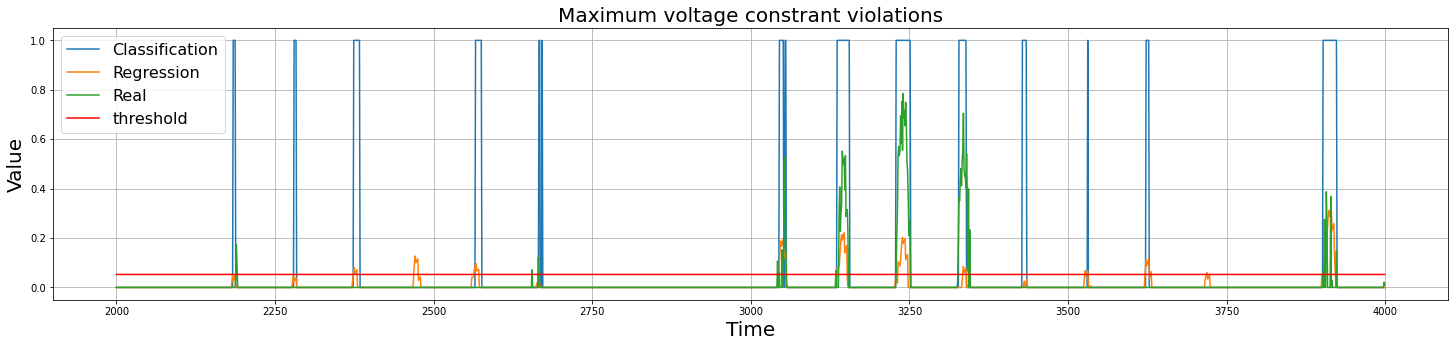

In [14]:
scaled_threshold_signal = pd.DataFrame(scaled_threshold * np.ones(len(reg_result['bus_16'])), index=class_result.index, columns=['threshold'])
fig = plt.figure(figsize=(25, 5))
class_result['bus_16'][2000:4000].plot()
reg_result['bus_16'][2000:4000].plot()
data_max_u_sparse['y_test']['bus_16'][2000:4000].plot()
plt.plot(scaled_threshold_signal[2000:4000], color='red')
# set legend, title with font size 16, labels with font size 14, grid 
plt.legend(['Classification', 'Regression', 'Real', 'threshold'], fontsize=16)
plt.title('Maximum voltage constrant violations', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.grid()
plt.show()

As one can see that the classification model is sometimes able to filter out FP results, such as the one around the time step 2500. However, not all are affected.

Now the hybrid signal is.

In [15]:
hybrid_result = deepcopy(reg_result)
hybrid_result[class_result.columns] = class_result * reg_result[class_result.columns]

In [16]:
metric.get_prediction_scores(hybrid_result, data_max_u_sparse['y_test'], threshold=scaled_threshold)
hybrid_accuracy = metric.hybrid_accuracy
hybrid_precision = metric.hybrid_precision
hybrid_recall = metric.hybrid_recall
hybrid_f1 = metric.hybrid_f1
hybrid_mcc = metric.hybrid_mcc
hybrid_evaluation = pd.Series({'recall': hybrid_recall, 'precision': hybrid_precision, 'f1': hybrid_f1, 'accuracy': hybrid_accuracy, 'mcc': hybrid_mcc})
# Buidl a df with all the results
final_max_u_eval = pd.DataFrame({'reg': reg_evaluation, 'hybrid': hybrid_evaluation})
final_max_u_eval.T

true_positives_ctr:  2949
true_negatives_ctr:  300490
false_positives_ctr:  2057
false_negatives_ctr:  2000
2267316621955988820


,accuracy,f1,mcc,precision,recall
reg,0.977467,0.507041,0.540358,0.366413,0.822844
hybrid,0.983503,0.484816,0.476442,0.481909,0.487757


In [17]:
def experiment_string(value):
    output = ''
    if 'reg' in value:
        output += 'Regression'
    elif 'hybrid' in value:
        output += 'Hybrid'
    return output
def print_df_in_latex(df):
    for index, row in df.iterrows():
        print( experiment_string(index) + ' & ' + str(round(row['accuracy'], 2)) + ' & ' + str(round(row['precision'], 2)) + ' & ' + str(round(row['recall'], 2)) + ' & ' + str(round(row['f1'], 2)) +' & ' + str(round(row['mcc'], 2)) + ' \\\\')
print_df_in_latex(final_max_u_eval.T)

Regression & 0.98 & 0.37 & 0.82 & 0.51 & 0.54 \\
Hybrid & 0.98 & 0.48 & 0.49 & 0.48 & 0.48 \\


From the results one cann see an improvement of 10% on the precision score. And since the MCC score and F1 score are only affected by about 6% and 2%, respectively, the hybrid model improves the results.

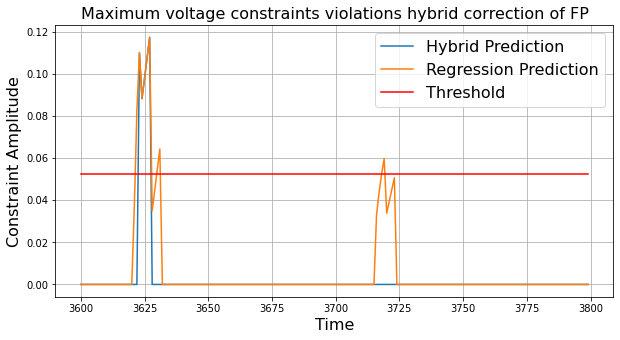

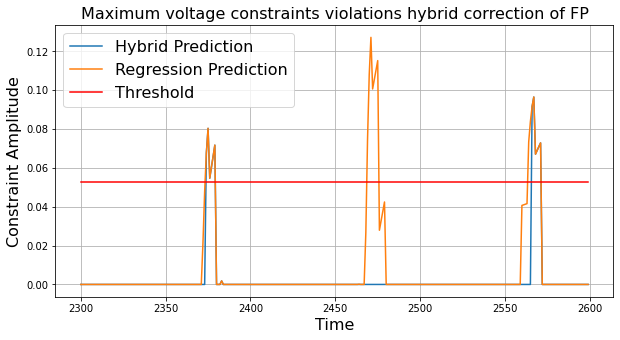

In [18]:
scaled_threshold_signal = pd.DataFrame(scaled_threshold * np.ones(len(reg_result['bus_16'])), index=class_result.index, columns=['threshold'])
fig = plt.figure(figsize=(10, 5))
hybrid_result['bus_16'][3600:3800].plot()
reg_result['bus_16'][3600:3800].plot()
plt.plot(scaled_threshold_signal[3600:3800], color='red')
# set legend, title with font size 16, labels with font size 14, grid 
plt.legend(['Hybrid Prediction', 'Regression Prediction', 'Threshold'], fontsize=16)
plt.title('Maximum voltage constraints violations hybrid correction of FP', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Constraint Amplitude', fontsize=16)
plt.grid()
plt.show()
scaled_threshold_signal = pd.DataFrame(scaled_threshold * np.ones(len(reg_result['bus_16'])), index=class_result.index, columns=['threshold'])
fig = plt.figure(figsize=(10, 5))
hybrid_result['bus_16'][2300:2600].plot()
reg_result['bus_16'][2300:2600].plot()
plt.plot(scaled_threshold_signal[2300:2600], color='red')
# set legend, title with font size 16, labels with font size 14, grid 
plt.legend(['Hybrid Prediction', 'Regression Prediction', 'Threshold'], fontsize=16)
plt.title('Maximum voltage constraints violations hybrid correction of FP', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Constraint Amplitude', fontsize=16)
plt.grid()
plt.show()

From the Figures, it is possible to see that the hybrid model is able to filter out the FP results.

#### Min_u

First we load the models for min_u.


In [19]:
# Load models
classifier_min_u_sparse = utils.deserialize_object('pickles\dataset_benchmark\min_u_classifier')
regression_min_u_sparse = utils.deserialize_object('pickles\dataset_benchmark\min_u_regressor_sparse')
min_u_class_gb = deepcopy(classifier_min_u_sparse.strategies[1])
print(min_u_class_gb)
min_u_reg_gb = deepcopy(regression_min_u_sparse.strategies[1])
print(min_u_reg_gb)
class_result = min_u_class_gb.predict(data_min_u_bool)
reg_result = min_u_reg_gb.predict(data_min_u_sparse)

Now we evaluate the models.

In [24]:
metric = metrics.Metrics()
tp, tn, fp, fn = metric.compute_confusion_matrix(class_result, data_min_u_bool['y_test'])
# Classification
class_recall = metric.compute_recall(tp, fn)
class_precision = metric.compute_precision(tp, fp)
class_f1 = metric.compute_f1(class_recall, class_precision)
class_accuracy = metric.compute_accuracy(tp, tn, fp, fn)
class_mcc = metric.compute_mcc(tp, tn, fp, fn)
class_evaluation_min_u = pd.Series({'accuracy': class_accuracy, 'precision': class_precision, 'recall': class_recall, 'f1': class_f1, 'mcc': class_mcc})
# Regression
_threshold = lambda experiment: max_u_threshold / data_max_u_sparse['scaler']['y'] if 'max_u' in experiment else min_u_threshold/ data_min_u_sparse['scaler']['y']
scaled_threshold = _threshold('min_u')
metric.get_prediction_scores(reg_result, data_min_u_sparse['y_test'], threshold=scaled_threshold)
reg_accuracy = metric.hybrid_accuracy
reg_precision = metric.hybrid_precision
reg_recall = metric.hybrid_recall
reg_f1 = metric.hybrid_f1
reg_mcc = metric.hybrid_mcc
reg_evaluation_min_u = pd.Series({'accuracy': reg_accuracy, 'precision': reg_precision, 'recall': reg_recall, 'f1': reg_f1, 'mcc': reg_mcc})
pd.DataFrame([class_evaluation_min_u, reg_evaluation], index=['classification', 'regression'])

true_positives_ctr:  5039
true_negatives_ctr:  294582
false_positives_ctr:  6892
false_negatives_ctr:  983
6402070686261354420


,accuracy,precision,recall,f1,mcc
classification,0.936544,0.517575,0.691963,0.592198,0.565496
regression,0.977467,0.366413,0.822844,0.507041,0.540358


In [26]:
def experiment_string(value):
    output = ''
    if 'classification' in value:
        output += 'Classification'
    elif 'regression' in value:
        output += 'Regression'
    return output
def print_df_in_latex(df):
    for index, row in df.iterrows():
        print( experiment_string(index) + ' & ' + str(round(row['accuracy'], 2)) + ' & ' + str(round(row['precision'], 2)) + ' & ' + str(round(row['recall'], 2)) + ' & ' + str(round(row['f1'], 2)) +' & ' + str(round(row['mcc'], 2)) + ' \\\\')
print_df_in_latex(pd.DataFrame([class_evaluation_min_u, reg_evaluation], index=['classification', 'regression']))

Classification & 0.94 & 0.52 & 0.69 & 0.59 & 0.57 \\
Regression & 0.98 & 0.37 & 0.82 & 0.51 & 0.54 \\


Since the classification model presents better results that the regression model, it can be used to filter the regression results. The main objective is to reduce the number of FP in the regression model, thus increase the precision score of the regression, without affecting too much the other metrics.

In [21]:
hybrid_result = deepcopy(reg_result)
hybrid_result[class_result.columns] = class_result * reg_result[class_result.columns]

In [25]:
metric.get_prediction_scores(hybrid_result, data_min_u_sparse['y_test'], threshold=scaled_threshold)
hybrid_accuracy = metric.hybrid_accuracy
hybrid_precision = metric.hybrid_precision
hybrid_recall = metric.hybrid_recall
hybrid_f1 = metric.hybrid_f1
hybrid_mcc = metric.hybrid_mcc
hybrid_evaluation = pd.Series({'accuracy': hybrid_accuracy, 'precision': hybrid_precision, 'recall': hybrid_recall, 'f1': hybrid_f1, 'mcc': hybrid_mcc})
# Buidl a df with all the results
final_min_u_eval = pd.DataFrame({'reg': reg_evaluation, 'hybrid': hybrid_evaluation})
final_min_u_eval.T

true_positives_ctr:  4105
true_negatives_ctr:  297953
false_positives_ctr:  3521
false_negatives_ctr:  1917
4151647144957209360


,accuracy,precision,recall,f1,mcc
reg,0.977467,0.366413,0.822844,0.507041,0.540358
hybrid,0.979452,0.460382,0.599239,0.520712,0.515033


In [27]:
def experiment_string(value):
    output = ''
    if 'reg' in value:
        output += 'Regression'
    elif 'hybrid' in value:
        output += 'Hybrid'
    return output
def print_df_in_latex(df):
    for index, row in df.iterrows():
        print( experiment_string(index) + ' & ' + str(round(row['accuracy'], 2)) + ' & ' + str(round(row['precision'], 2)) + ' & ' + str(round(row['recall'], 2)) + ' & ' + str(round(row['f1'], 2)) +' & ' + str(round(row['mcc'], 2)) + ' \\\\')
print_df_in_latex(final_min_u_eval.T)

Regression & 0.98 & 0.37 & 0.82 & 0.51 & 0.54 \\
Hybrid & 0.98 & 0.46 & 0.6 & 0.52 & 0.52 \\


From the results it is possible to see that the hybrid model is able to filter out the FP results, given that it double it's precision score. However, the recall is heavily affected by the hybrid model, since it wrongfully filters out some TP results. The F1 score and the MCC scores are negatively affected by the hybrid model in around 3% and 6%, respectively. Finally, it is to conclude that the the hybrid model is not able to improve the results.

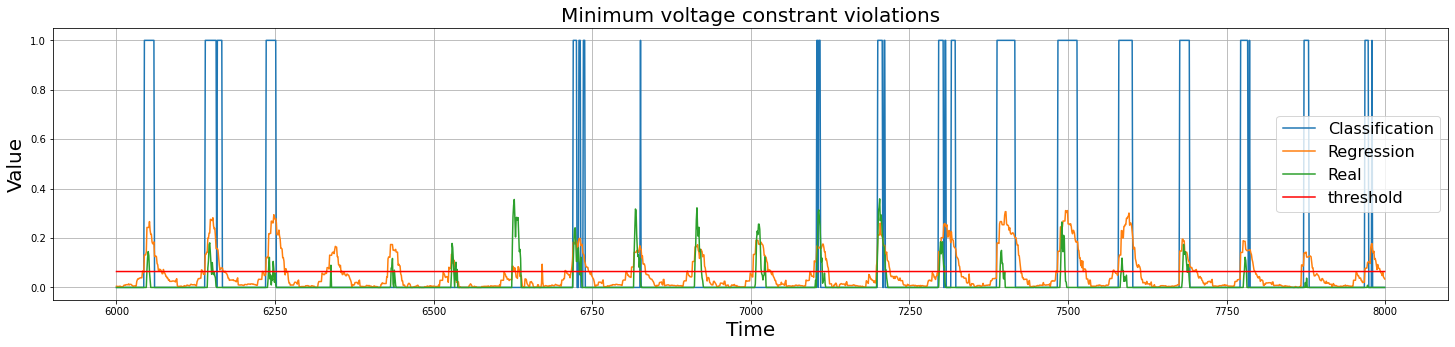

In [28]:
scaled_threshold_signal = pd.DataFrame(scaled_threshold * np.ones(len(reg_result['bus_16'])), index=class_result.index, columns=['threshold'])
fig = plt.figure(figsize=(25, 5))
class_result['bus_16'][6000:8000].plot()
reg_result['bus_16'][6000:8000].plot()
data_min_u_sparse['y_test']['bus_16'][6000:8000].plot()
plt.plot(scaled_threshold_signal[6000:8000], color='red')
# set legend, title with font size 16, labels with font size 14, grid 
plt.legend(['Classification', 'Regression', 'Real', 'threshold'], fontsize=16)
plt.title('Minimum voltage constrant violations', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Value', fontsize=20)

plt.grid()
plt.show()

From the Figure it is possible to see that the classification model filters out some FP results, but it also filters out some TP results.